In [1]:
## Generate Diffusion Map in order to calculate diffusion pseudotime
## and plot smoothed gene expression along dpt ordering

import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import seaborn as sb

# Some custom functions
import ma_codes as codes
from ma_codes import mysize, mymap, gray_red

sc.settings.verbosity = 3               # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_version_and_date()

Running Scanpy 1.5.1, on 2020-09-29 12:39.


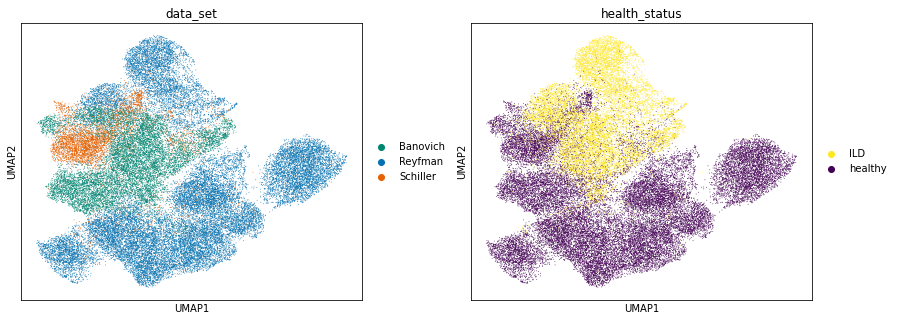

In [2]:
## Example object - Epithelium from human multi-cohort integration data set
plt.rcParams["figure.figsize"] = (6, 5)
folder = "/mnt/platte_2/Projects/191118_MLT-ASK_multiomics/remerge_raw/"

adata = sc.read(folder + "200922_SchiReyf_AT2basaloid.h5ad")
sc.pl.umap(adata, color = ["data_set", "health_status"], wspace = 0.2)

### Generate a subset of trajectory of interest (ILD cells)

In [3]:
import warnings
warnings.filterwarnings("ignore")

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


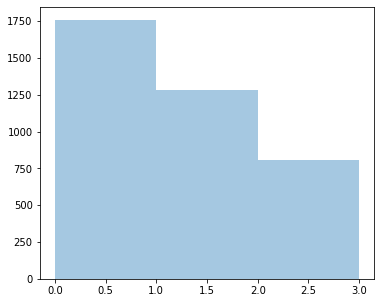

In [4]:
sub = adata[adata.obs.health_status == "ILD"].copy()

## Recalculate variable genes if desired, usually not necessary
adata_raw = sc.AnnData(X = sub.raw.X)
adata_raw.obs = sub.obs
adata_raw.var = sub.raw.var.copy()

batch = "data_set"
sc.pp.highly_variable_genes(adata_raw, min_disp = None, max_disp = None, min_mean = None, max_mean = None, 
                                batch_key = batch, n_top_genes = 4000, n_bins = 20, flavor = "cell_ranger", 
                                subset = False)

vartab = pd.DataFrame(adata_raw.var["highly_variable_nbatches"], index = adata.var_names)
sb.distplot(vartab, kde = False, bins = len(np.unique(adata_raw.obs[batch])))

In [5]:
thresh = 2
hvgs = vartab[vartab.highly_variable_nbatches.values >= thresh].index
print("%s Genes will be kept, variable in at least %s samples" %(len(hvgs), thresh))

804 Genes will be kept, variable in at least 2 samples


In [6]:
del(adata_raw)
sub.var["highly_variable"] = [g in hvgs for g in sub.var_names]
sum(sub.var["highly_variable"])

804

### Recalculate PCs and Visualizations

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


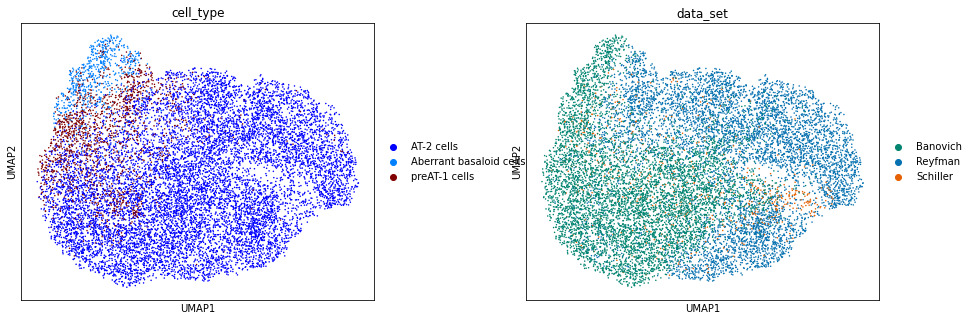

In [7]:
import bbknn
sc.pp.pca(sub, use_highly_variable = True)

bbknn.bbknn(sub, neighbors_within_batch = 5, n_pcs = 6, batch_key = "data_set")
#sc.pp.neighbors(sub, n_pcs = 8, n_neighbors = 6)  ## without bbknn

sc.tl.umap(sub)
sc.pl.umap(sub, color = ["cell_type", "data_set"], wspace = 0.3)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9926073  0.9874296  0.98431796 0.98059726 0.9784057
     0.97373205 0.97116613 0.9689312  0.96515375 0.9636162  0.9593832
     0.9592317  0.95695955 0.9552394 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


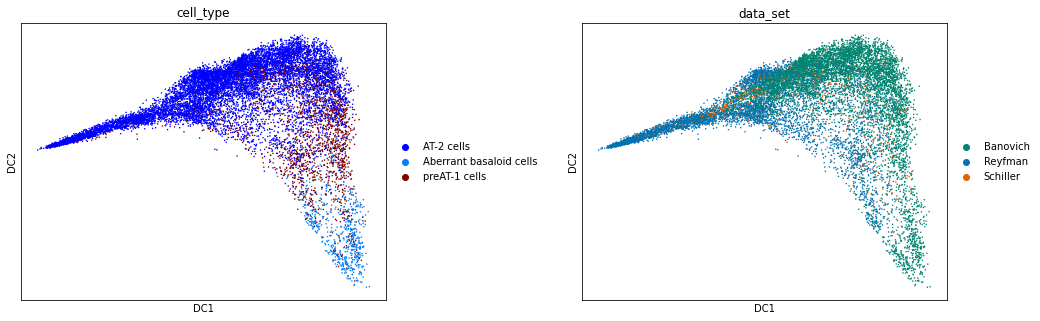

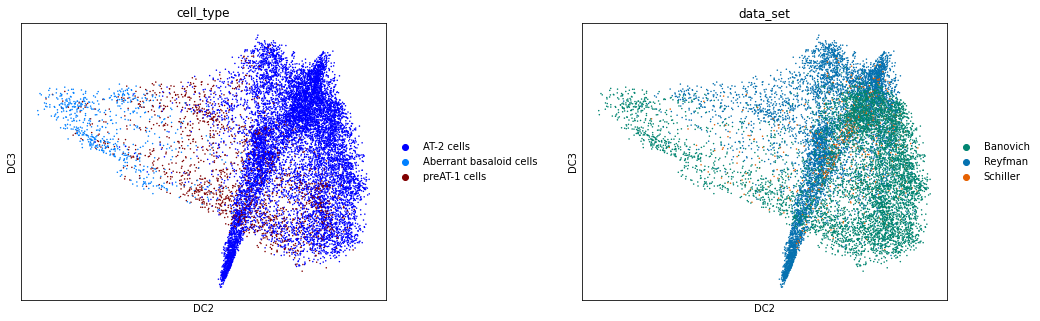

In [8]:
#del(sub.obsm["X_diffmap"])   ## uncomment this if you get this "not supported between int and string" error...
sc.tl.diffmap(sub)
sc.pl.diffmap(sub, color = ["cell_type", "data_set"], wspace = 0.4)
sc.pl.diffmap(sub, color = ["cell_type", "data_set"], wspace = 0.4, components = "2,3")

### Calculate Diffusion Pseudotime after specifying root cell

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


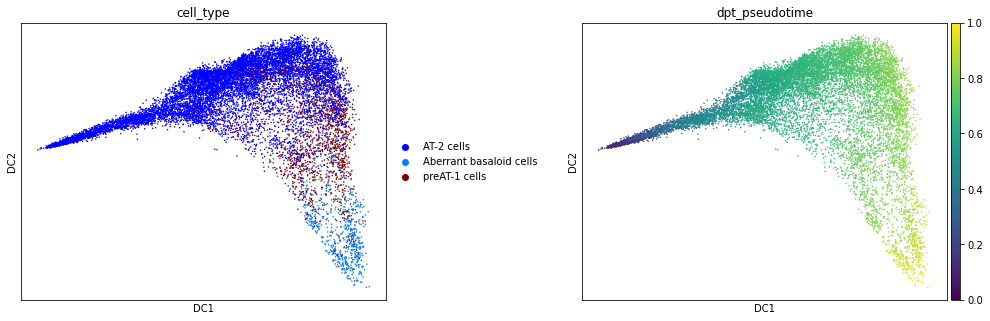

In [9]:
## Set smallest DC1 as root [if you want the highest, then use np.argmax()]
root_id = np.arange(sub.n_obs)[np.argmin(sub.obsm['X_diffmap'][:, 1])]
sub.uns['iroot'] = root_id

sc.tl.dpt(sub)
sc.pl.diffmap(sub, color = ["cell_type", "dpt_pseudotime"], wspace = 0.4)

### Plot DPT ordered gene expression for multiple genes

In [10]:
plot_folder = "/path/to/folder/"
genes = ["CRTAC1", "SOX4"]
xlabel = "dpt_pseudotime"
cols = ["tab:green", "tab:blue", "tab:red", "tab:orange", "mediumvioletred", "lightskyblue", "turquoise"]

genes = ["SFTPC", "KRT8", "SPRR1A", "SFN", "SOX4", "CEBPD", "CRTAC1"]
genExp = sc.get.obs_df(sub, keys = genes + [xlabel], layer = None, use_raw = True)
genExp.head(2)

,SFTPC,KRT8,SPRR1A,SFN,SOX4,CEBPD,CRTAC1,dpt_pseudotime
index,,,,,,,,
GSM3489183:AAACCTGGTAAGGGCT,7.069688,0.0,0.0,0.00000,0.818587,1.262596,0.00000,0.629407
GSM3489183:AAAGTAGCAAGTACCT,7.077327,0.0,0.0,0.50453,1.088098,0.504530,0.50453,0.658053


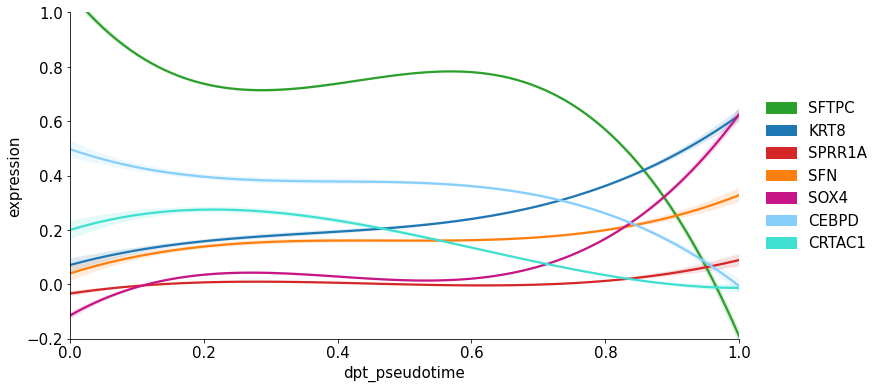

In [11]:
codes.plot_genExp_dpt_ordered(genExp, genes, xlabel, order = 3, ci = 95, figsize = (12, 6), label_size = 15,
                              cols = cols, scale = True, ylim = (-0.2, 1))  

## add parameter if you want to save the plot: save = plot_folder + "name_of_plot.pdf"

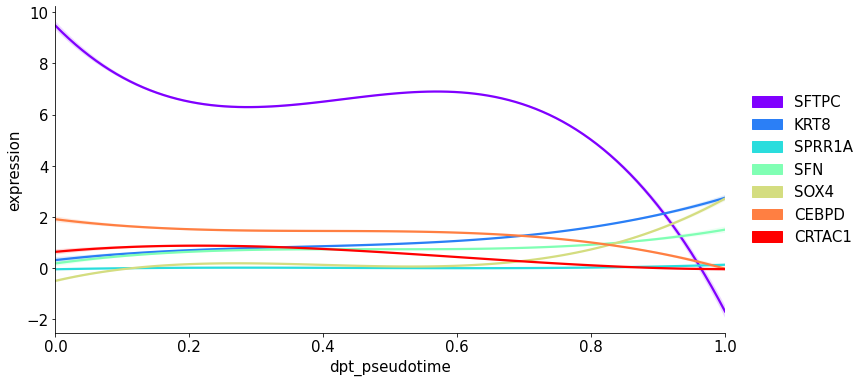

In [12]:
## you don’t have to scale, provide colors or y-Axis limits
codes.plot_genExp_dpt_ordered(genExp, genes, xlabel, order = 3, ci = 95, figsize = (12, 6), label_size = 15,
                              cols = None, scale = False, ylim = None)

### Plot single gene split by condition

In [21]:
plot_folder = "/path/to/folder/"

condition = "data_set"                 ## specify column where condition is stored
cols = sub.uns["%s_colors" %condition]

genes = ["CRTAC1"]
xlabel = "dpt_pseudotime"

genExp = sc.get.obs_df(sub, keys = genes + [xlabel, condition], layer = None, use_raw = True)
genExp.head(2)

,CRTAC1,dpt_pseudotime,data_set
index,,,
GSM3489183:AAACCTGGTAAGGGCT,0.00000,0.629407,Reyfman
GSM3489183:AAAGTAGCAAGTACCT,0.50453,0.658053,Reyfman


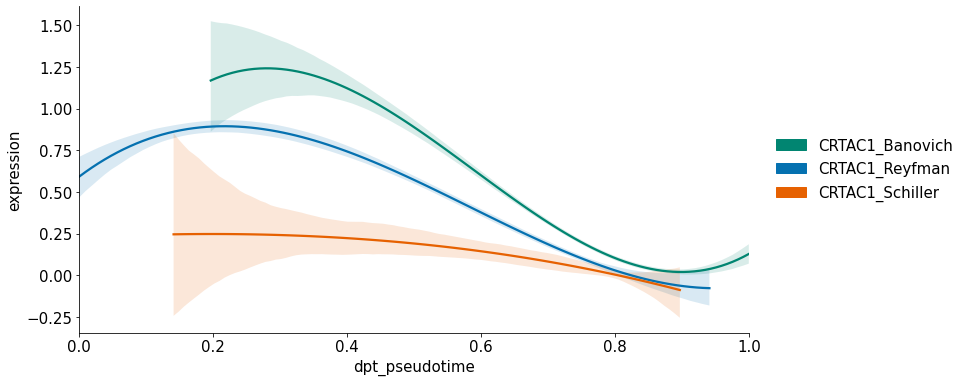

In [22]:
codes.plot_genExp_dpt_ordered(genExp, genes, xlabel, order = 3, ci = 95, figsize = (12, 6), label_size = 15,
                              cols = cols, scale = False, ylim = None, condition = condition)  

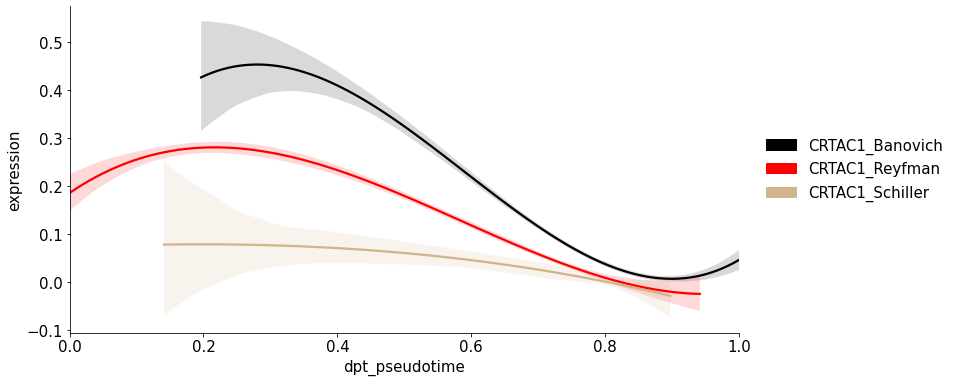

In [25]:
# Scale by data set
codes.plot_genExp_dpt_ordered(genExp, genes, xlabel, order = 3, ci = 95, figsize = (12, 6), label_size = 15,
                              cols = ["black", "red", "tan"], scale = True, ylim = None, condition = condition)  